In [ ]:
#originally runnable on google collab
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Lambda, Dot, Activation, Concatenate, Layer
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [ ]:
df = pd.read_csv('/content/GE.csv')
df.head() #displays feature column

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-13,7.13,7.13,6.76,7.02,6.986340,94074500
1,2020-04-14,7.10,7.24,6.84,6.93,6.896772,107067200
2,2020-04-15,6.73,6.73,6.35,6.50,6.468834,138220800
3,2020-04-16,6.48,6.54,6.20,6.24,6.210080,165678200
4,2020-04-17,6.47,6.94,6.34,6.84,6.807204,165907800


In [ ]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

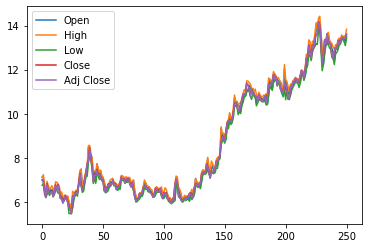

In [ ]:
#Variables for training
cols = list(df)[1:6] #extracts relevant features i.e from column 1 (Open) to Column 5 (Adj Close)

df_for_training = df[cols].astype(float)
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
#normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[-0.62936169, -0.68478389, -0.7168296 , -0.66632603, -0.6707062 ],
       [-0.641084  , -0.64232895, -0.68512209, -0.70137867, -0.70548719],
       [-0.78565909, -0.83916549, -0.87933055, -0.8688524 , -0.87166379],
       ...,
       [ 1.82060009,  1.78532173,  1.85940507,  1.814622  ,  1.81595882],
       [ 1.765896  ,  1.77374311,  1.79202662,  1.83799043,  1.83925798],
       [ 1.85967444,  1.90110793,  1.92282007,  1.89641149,  1.89750588]])

In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 

trainX = []
trainY = []

In [ ]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future

In [ ]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [ ]:
#LSTMs with Attention

class Attention(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        
        # first we inpect what happens inside the first dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # W is the trainable weight matrix -> in this case it is hidden size
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        

        #wraps an arbitrary expression as a layer object in this case it is simply the last hidden state of our last LSTM layer
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states) 



        #Dot layer simply computes a Dot Product
        #In this case it is the Dot product of the attention score vector and the last hidden state which gives us the score of the attention 
        #we can use the score in order to train the attention layer as it is our goal to maximise it
        score = Dot(axes=[1, 2], name='attention_score')([h_t, score_first_part])



        #This simply applies the softmax activation function to our score
        attention_weights = Activation('softmax', name='attention_weight')(score)


        # In this section we calculate the dot product of the attention weights and the hidden states that are inout into our Aattention layer
        # We then concatenate that context vector with the hidden states that we input to the attention layer
        # We then take this and apply a normal dense layer with tanh activation which returns out attention vector
        context_vector = Dot(axes=[1, 1], name='context_vector')([hidden_states, attention_weights])
        pre_activation = Concatenate(name='attention_output')([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(Attention(16))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_4 (LSTM)                (None, 14, 32)            12416     
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 16)            3136      
_________________________________________________________________
last_hidden_state (Lambda)   (None, 16)                0         
_________________________________________________________________
attention_score_vec (Dense)  (None, 14, 16)            256       
_________________________________________________________________
attention_score (Dot)        (None, 14)                0         
_________________________________________________________________
attention_weight (Activation (None, 14)               

Epoch 1/10
22/22 [==============================] - 4s 54ms/step - loss: 0.5952 - val_loss: 1.0038
Epoch 2/10
22/22 [==============================] - 0s 18ms/step - loss: 0.1055 - val_loss: 0.7300
Epoch 3/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0791 - val_loss: 0.1202
Epoch 4/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0808 - val_loss: 0.4382
Epoch 5/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0819 - val_loss: 0.2969
Epoch 6/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0670 - val_loss: 0.2789
Epoch 7/10
22/22 [==============================] - 0s 18ms/step - loss: 0.0549 - val_loss: 0.1327
Epoch 8/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0635 - val_loss: 0.2313
Epoch 9/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0582 - val_loss: 0.2705
Epoch 10/10
22/22 [==============================] - 0s 18ms/step - loss: 0.0563 - val_loss: 0.2386


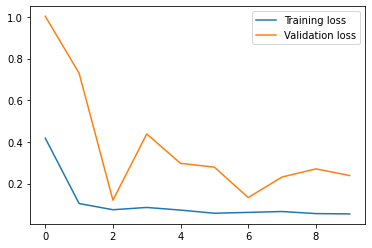

In [ ]:
history = model.fit(trainX, trainY, epochs=10, batch_size=10, validation_split=0.1, verbose=1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


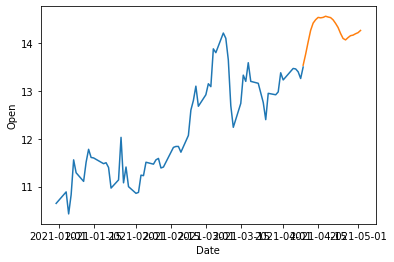

In [ ]:
n_future=24 #predicts the next 24 values
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) 
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1) #copy the columns so that the shape is correct
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0] #just look at 0 column which is the opening price
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-12-31']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])